Assignment 2: 

Name: **ASHUTOSH REDDY ATIMYALA**

UID: **118442129**

Please submit to ELMS
- a PDF containing all outputs (by executing **Run all**)
- your ipynb notebook containing all the code

I understand the policy on academic integraty (collaboration and the use of online material).
Please sign your name here:   
**ASHUTOSH REDDY ATIMYALA**


In [1]:
## Import necessary libraries here (You can add libraries you want to use here)
import cv2
import numpy as np
from scipy.io import loadmat
from scipy import ndimage
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow ## Use this to show image in colab
%matplotlib inline
import time

# Part 1: A Feature Tracker (50 Points)

## Overview

In the problem, you will implement a corner detector and feature tracker that track features from the image sequence hotel. Since this is a two part problem, we have included precomputed intermediate results in the *Data* section in case you’re unable to complete any portion.

<img src="https://drive.google.com/uc?id=1sBtKpU2mYEPZ9c2Cvw-DBuLBPK2gYwC-" width="700"/>

**Note:**  Do not use existing keypoint
detectors, trackers, or structure from motion code, such as found on the web, and OpenCV.

## Data

**WARNING: Colab deletes all files everytime runtime is disconnected. Make sure to re-download the inputs when it happens.**

In [2]:
# Download Data -- run this cell only one time per runtime
!gdown 1fT0H-FbbDZnjMfCJHZcscpcwAXHhGgNw
!unzip "/content/part1_images.zip" -d "/content/"
!gdown 1r-Pdino6MRLCEWX_sQOgd8D5AVsRc7Ym
# Load Initial Key Points
data = loadmat('/content/initial_keypoints.mat')
X0 = data['Xo']
Y0 = data['Yo']

Downloading...
From: https://drive.google.com/uc?id=1fT0H-FbbDZnjMfCJHZcscpcwAXHhGgNw
To: /content/part1_images.zip
100% 5.10M/5.10M [00:00<00:00, 152MB/s]
Archive:  /content/part1_images.zip
   creating: /content/part1_images/
  inflating: /content/part1_images/hotel.seq41.png  
  inflating: /content/part1_images/hotel.seq40.png  
  inflating: /content/part1_images/hotel.seq42.png  
  inflating: /content/part1_images/hotel.seq43.png  
  inflating: /content/part1_images/hotel.seq47.png  
  inflating: /content/part1_images/hotel.seq46.png  
  inflating: /content/part1_images/hotel.seq50.png  
  inflating: /content/part1_images/hotel.seq44.png  
  inflating: /content/part1_images/hotel.seq8.png  
  inflating: /content/part1_images/hotel.seq9.png  
  inflating: /content/part1_images/hotel.seq45.png  
  inflating: /content/part1_images/hotel.seq36.png  
  inflating: /content/part1_images/hotel.seq22.png  
  inflating: /content/part1_images/hotel.seq23.png  
  inflating: /content/part1_imag

## Helper Functions

In [3]:
def readImages(folder, num_images):
  arr_images = []
  for i in range(num_images):
    arr_images.append(cv2.imread(f'{folder}hotel.seq{i}.png'))
  return np.array(arr_images, dtype=np.float32)

def trackPoints(pt_x, pt_y, im, ws):
  '''
  Tracking initial points (pt_x, pt_y) across the image sequence
  Outputs:
    track_x: [Number of keypoints] x [2]
    track_y: [Number of keypoints] x [2]
  '''
  N = np.prod(pt_x.shape)
  nim = len(im)
  track_x = np.zeros((N, nim))
  track_y = np.zeros((N, nim))
  track_x[:,0] = pt_x
  track_y[:,0] = pt_y

  for t in range(nim-1):
    track_x[:, t+1], track_y[:, t+1] = getNextPoints(track_x[:, t], track_y[:, t], im[t,:,:], im[t+1,:,:], ws)
  return track_x, track_y

# read all 51 sequences of images
folder = '/content/part1_images/'
im = readImages(folder, 51) 

## 1.1 Keypoint Selection (15 pts)

For the first frame, use the second moment matrix to locate strong corners to use as keypoints.
These points will be tracked throughout the sequence in the second part of the problem. Choose a proper threshold so that edges and noisy patches are ignored. Do local non-maxima suppression over a 5x5 window centered at each point.
This should give several hundred good points to track.

### Code (5 pts)

Number of Corners Detected: 701


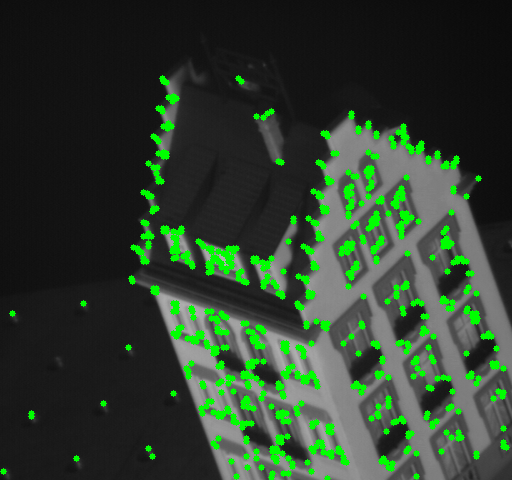

In [4]:
def getKeypoints(img, tau):
  '''
  Detecting keypoints using Harris corner criterion
  img: input image
  tau: threshold 
  
  output: (N,2) array of [x,y] keypoints
  '''
  #BGR2GRAY
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  #GaussianBlur
  img = cv2.GaussianBlur(img, (5, 5), 1).astype('float32')
  #shape of the image
  height, width = img.shape[0],img.shape[1]
  #Harriscornerdetected
  R = np.zeros((height,width))
  #Sobelfilter
  sobel_x = np.array(([-1,0,1],[-2,0,2],[-1,0,1]))
  sobel_y = sobel_x.T
  #Gradients along x and y direction
  ix =  cv2.filter2D(img,-1,sobel_x) # derivative of gaussian along x direction
  iy =  cv2.filter2D(img,-1,sobel_y)# derivative of gaussian along y direction
  
  Ixx = np.power(ix,2)
  Iyy = np.power(iy,2)
  Ixy = ix*iy
  #Weighted average filter
  kernel2 = np.ones((3, 3), np.float32)/25
  kernel2 = np.array((
    [1/16, 2/16, 1/16],
    [2/16, 4/16, 2/16],
    [1/16, 2/16, 1/16]), dtype="float64")
  #gradients after applying the average filter
  Ixx = cv2.filter2D(np.power(ix,2), -1, kernel2)
  Iyy = cv2.filter2D(np.power(iy,2), -1, kernel2)
  Ixy = cv2.filter2D(ix*iy, -1, kernel2)
  #creating a window
  window_size = 3
  offset = int( window_size / 2 )
  #Computing the harris corner score for a selected window size over the image.
  for y in range(offset, height-offset):
        for x in range(offset, width-offset):
            Sx2 = np.sum(Ixx[y-offset:y+1+offset, x-offset:x+1+offset]) 
            Sy2 = np.sum(Iyy[y-offset:y+1+offset, x-offset:x+1+offset])
            Sxy = np.sum(Ixy[y-offset:y+1+offset, x-offset:x+1+offset])
            H = np.array([[Sx2,Sxy],[Sxy,Sy2]]) #second moment matrix for feaature patch in the image. 
            det = np.linalg.det(H) #determinant of the H matrix.
            tr = np.matrix.trace(H) #trace of the H matrix.
            R[y-offset, x-offset] = det / tr #Harris corner score for the feature patch.
  cv2.normalize(R, R, 0, 1, cv2.NORM_MINMAX) #normalizing the overall Harris corner detected image
  cornerList = []
  #Non-maximum supression 
  for y in range(offset, height-offset,5):
        for x in range(offset, width-offset,5):
            value=R[y-offset:y+1+offset, x-offset:x+1+offset]
            _, max_v, _, max_loc = cv2.minMaxLoc(value)
            if max_v>tau:
                cornerList.append([x+max_loc[0], y+max_loc[1]])
  return np.array(cornerList)

# compute keypoints in the first sequence
tau = 0.07
key_pts = getKeypoints(im[0], tau)
print('Number of Corners Detected:', key_pts.shape[0])
img_cpy = im[0].copy()

# add plots for the write-up
for x,y in key_pts:
  cv2.circle(img_cpy,(x,y),3,(0,255,0),-1)
result_keypoints = img_cpy 
cv2_imshow(result_keypoints)

### Write-up (10 pts)


*   (5 pts) Explain your implementation of getKeypoints()
*   (5 pts) Display the first frame of the sequence overlaid with the detected keypoints. Ensure that they are clearly visible (plot with `color='g' and linewidths=3`)



**getKeypoints()**:

Inputs : 
1. img - input image. 
2. tau - threshold for the Non-maximum supression.

Output:  
- x,y Keypoints detected of shape [Nx2].

Primarily, the image is converted to a gray-scale image and gaussian blur(optional) is applied to get a smoothened image. Secondly, the derivate of gaussian along x and y directions are computed using sobel filter and also, weighted average filtered Ixx,Ixy,Iyy are calculated. For a user-defined window size, the harris corner score is computed on the overall image by sliding window method. Finally, non-maximum supression is applied to the over-all harris corners score where the maximum value, that is greater then the threshold(tau), is selected over the window size of 15x15 and an array of the keypoints detected is returned.


## 1.2 Feature Tracking (35 pts)

Apply the Kanade-Lucas-Tomasi tracking procedure to track the keypoints found in part 1.1 (or the given keypoints in the *Data* section) throughout the hotel sequence. 

<img src="https://drive.google.com/uc?id=1dU4p4YcnXoQFnrNvleEty_4tDECkVW9Q" width="500"/>

Some keypoints will move out of the image frame over the course of the sequence. Discard any track if the predicted translation falls outside the image frame.

**Hint:**

*  From the 1st frame to the 2nd frame, use the detected keypoints at the first frame as initialization points. From the 2nd to 3rd frame, use the tracked positions at the 2nd frame as initialization. Note that the tracked keypoints in general are not at integer positions.

*  For each point, use a window size of 15 x 15.

Add codes to **plot** your tracked points overlayed in the **first sequence** and the **last sequence**. They should look similar to the second picture shown in the Overview section. 



### Code (10 pts)

The Number of Keypoints detected: 701


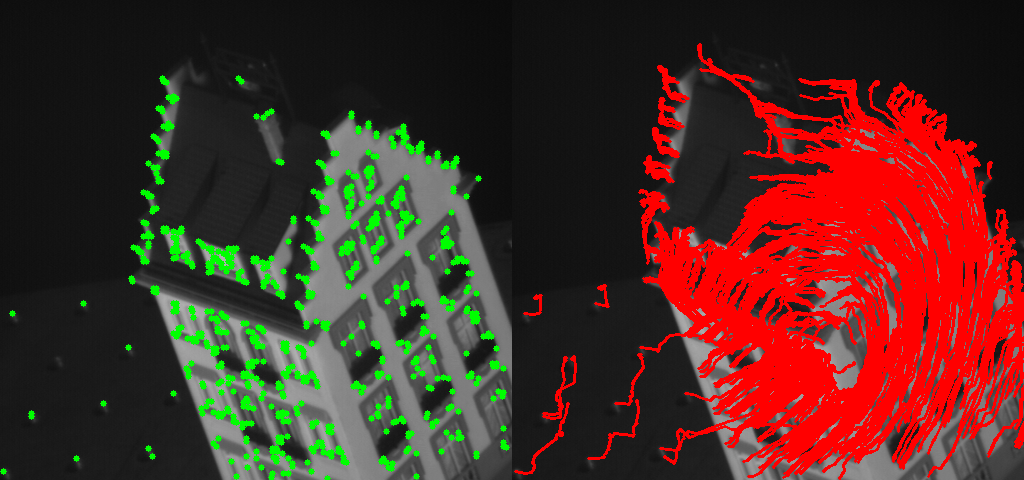


The Progression of Image Coordinates for each of the  20 random keypoints


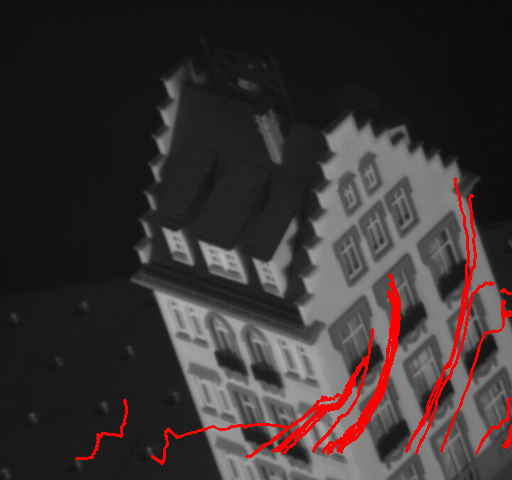


Visualizing the Outliers


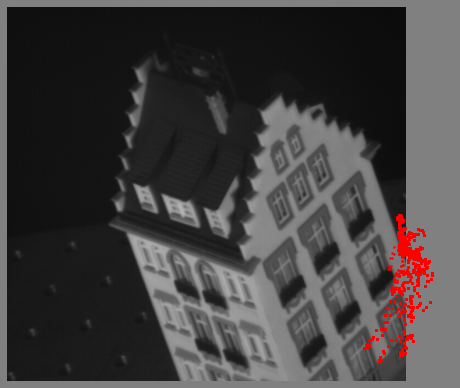

In [5]:
def getNextPoints(x, y, im1, im2, ws):
    '''
    Iterative Lucas-Kanade feature tracking
    x,  y : initialized keypoint position in im2
    ws: patch window size

    output: tracked keypoint positions in im2
    '''
    #BGR2GRAY
    im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
    im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)
    #Initializing: x_prime and y_prime
    x_prime = np.copy(x)
    y_prime = np.copy(y)
    #Gradients along x and y direction
    iy, ix = np.gradient(im1)
    hw = int(ws/2)

    for i in range(len(x)):
        #Gradients in x and y direction for the window
        Ix = cv2.getRectSubPix(ix, (ws, ws), (x[i], y[i]))
        Iy = cv2.getRectSubPix(iy, (ws, ws), (x[i], y[i]))
        #sum of squared gradients of the image
        Sx2 = np.sum(Ix**2)
        Sxy = np.sum(Ix * Iy)
        Sy2 = np.sum(Iy**2)

        I_t = cv2.getRectSubPix(im2, (ws, ws), (x_prime[i], y_prime[i])) - cv2.getRectSubPix(im1, (ws, ws), (x[i], y[i]))

        for j in range(5):
            #second moment matrix
            A = np.array([[Sx2, Sxy], 
                          [Sxy, Sy2]])
            b = np.array([(np.sum(Ix * I_t)), (np.sum(Iy * I_t))])

            try:
                d = np.linalg.solve(A, b)
            except np.linalg.LinAlgError:
                pass

            x_prime[i] += d[0]
            y_prime[i] += d[1]
            #condition for the outliers
            if x_prime[i] > hw and x_prime[i] < im.shape[1]-hw and y_prime[i] > hw and y_prime[i] < im.shape[0]-hw:
                I_t = cv2.getRectSubPix(im2, (ws, ws), (y_prime[i], y_prime[i])) - cv2.getRectSubPix(im1, (ws, ws), (x[i], y[i]))
                break
            
    return x_prime, y_prime


ws = 15
tracked_pts = trackPoints(pt_x=key_pts[:,0], pt_y=key_pts[:,1], im=im, ws=ws)

#Visualizing the results
print('The Number of Keypoints detected:', key_pts[:,0].shape[0])
#Question 1:
result_1 = np.copy(im[0])

for i in range(tracked_pts[:][0].shape[0]):
    for j in range(tracked_pts[:][0][0].shape[0]-1):
        cv2.line(result_1, (int(tracked_pts[:][0][i][j]), int(tracked_pts[:][1][i][j])), (int(tracked_pts[:][0][i][j+1]), int(tracked_pts[:][1][i][j+1])), (0,0,255), 2)
result_1 = np.concatenate((result_keypoints,result_1), axis=1)
cv2_imshow(result_1)

#Question 2:
result_2 = np.copy(im[0])
print('\nThe Progression of Image Coordinates for each of the  20 random keypoints')

for i in range(650,670,1):   
    for j in range(tracked_pts[:][0][0].shape[0]-1):
        cv2.line(result_2, (int(tracked_pts[:][0][i][j]), int(tracked_pts[:][1][i][j])), (int(tracked_pts[:][0][i][j+1]), int(tracked_pts[:][1][i][j+1])), (0,0,255), 2)
cv2_imshow(result_2)

#Question 3:
print('\nVisualizing the Outliers')
plt.figure(figsize=(8, 8))
result_3 = np.array(im[0], dtype=np.uint8)
plt.gcf().set_facecolor('gray')
plt.axis('off')
plt.imshow(result_3, cmap='gray')

for i in (np.where(tracked_pts[0] > im[0].shape[1]))[0]:
    plt.scatter(tracked_pts[0][i].flatten(), tracked_pts[1][i].flatten(), s=2, c='r')

for j in (np.where(tracked_pts[1] > im[0].shape[0]))[0]:
    plt.scatter(tracked_pts[0][j].flatten(), tracked_pts[1][j].flatten(), s=2, c='r')

### Write-up (25 pts)

*   (5 pts) For all the keypoints, display (1) the keypoints at the first frame (as green) and (2) the tracked keypoints at the second frame (as red) on the first frame of the sequence.
*   (10 pts) For 20 random keypoints, draw the 2D path over the sequence of frames. That is, plot the progression of image coordinates for each of the 20 keypoints. Plot each of the paths on the same figure, overlaid on the first frame of the sequence.
*   (10 pts) On top of the first frame, plot the points which have moved out of frame at some point along the sequence.





# Part 2: Shape Alignment (30 Points)

## Overview
In this problem, you will write a function that aligns two sets of points using global image transformation (similarity, affine, or perspective) and returns $T$  where $T$ is a transformation that maps non-zero points in $im1$ to non-zero points in $im2$. You may choose the alignment algorithm and the type of (global) transformation (e.g., rigid Euclidean, affine, perspective).


<img src="https://drive.google.com/uc?id=1PnWIy9ZdP9SGkmGNtFCJ-JzKLwmW-qaN" width="1000"/>

Test your code on the 25 image pairs provided in the supplementary material. We have included functions 
**(will check) evalAlignmentAll and displayAlignment to help with evaluation and display**.




## Data

**WARNING: Colab deletes all files everytime runtime is disconnected. Make sure to re-download the inputs when it happens.**

In [6]:
# Download Data -- run this cell only one time per runtime
!gdown 18Px9uQyY1fGGyEAQhzt3h4yDQonU_Sgm
!unzip "/content/part2_images.zip" -d "/content/"

Downloading...
From: https://drive.google.com/uc?id=18Px9uQyY1fGGyEAQhzt3h4yDQonU_Sgm
To: /content/part2_images.zip
100% 78.4k/78.4k [00:00<00:00, 71.3MB/s]
Archive:  /content/part2_images.zip
   creating: /content/part2_images/
 extracting: /content/part2_images/Bone_1.png  
 extracting: /content/part2_images/elephant_1.png  
 extracting: /content/part2_images/brick_2.png  
 extracting: /content/part2_images/Heart_2.png  
 extracting: /content/part2_images/Bone_2.png  
  inflating: /content/part2_images/elephant_2.png  
 extracting: /content/part2_images/brick_1.png  
 extracting: /content/part2_images/Heart_1.png  
  inflating: /content/part2_images/device7_1.png  
  inflating: /content/part2_images/device7_2.png  
 extracting: /content/part2_images/fork_2.png  
 extracting: /content/part2_images/turtle_2.png  
  inflating: /content/part2_images/fork_1.png  
 extracting: /content/part2_images/turtle_1.png  
 extracting: /content/part2_images/butterfly_2.png  
 extracting: /content/pa

## Helper Functions

In [7]:
def evalAlignment(aligned1, im2):
  '''
  Computes the error of the aligned image (aligned1) and im2, as the
  average of the average minimum distance of a point in aligned1 to a point in im2
  and the average minimum distance of a point in im2 to aligned1.
  '''
  d2 = ndimage.distance_transform_edt(1-im2) #distance transform
  err1 = np.mean(np.mean(d2[aligned1 > 0]))
  d1 = ndimage.distance_transform_edt(1-aligned1);
  err2 = np.mean(np.mean(d2[im2 > 0]))
  err = (err1+err2)/2;
  return err

def displayAlignment(im1, im2, aligned1, thick=False):
  '''
  Displays the alignment of im1 to im2
     im1: first input image to alignment algorithm (im1(y, x)=1 if (y, x) 
      is an original point in the first image)
     im2: second input image to alignment algorithm
     aligned1: new1(y, x) = 1 iff (y, x) is a rounded transformed point from the first time 
     thick: true if a line should be thickened for display
  ''' 
  if thick:
    # for thick lines (looks better for final display)
    dispim = np.concatenate((cv2.dilate(im1.astype('uint8'), np.ones((3,3), np.uint8), iterations=1), \
                             cv2.dilate(aligned1.astype('uint8'), np.ones((3,3), np.uint8), iterations=1), \
                             cv2.dilate(im2.astype('uint8'), np.ones((3,3), np.uint8), iterations=1)), axis=-1)
  else:
    # for thin lines (faster)
    dispim = np.concatenate((im1, aligned1, im2), axis = -1)
  return dispim


## Code (15 pts)

apple :
Error in alignment: 190.82765391919844
Runtime: 0.34305453300476074  seconds


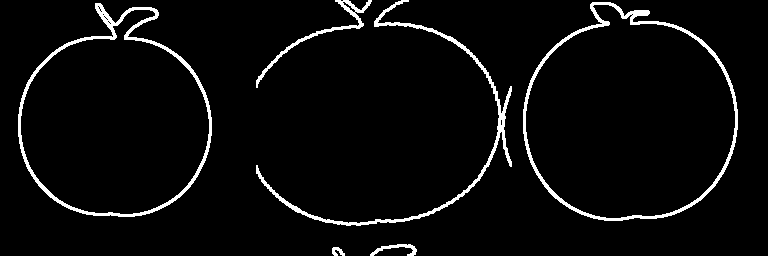



bat :
Error in alignment: 422.0975789638798
Runtime: 0.7777936458587646  seconds


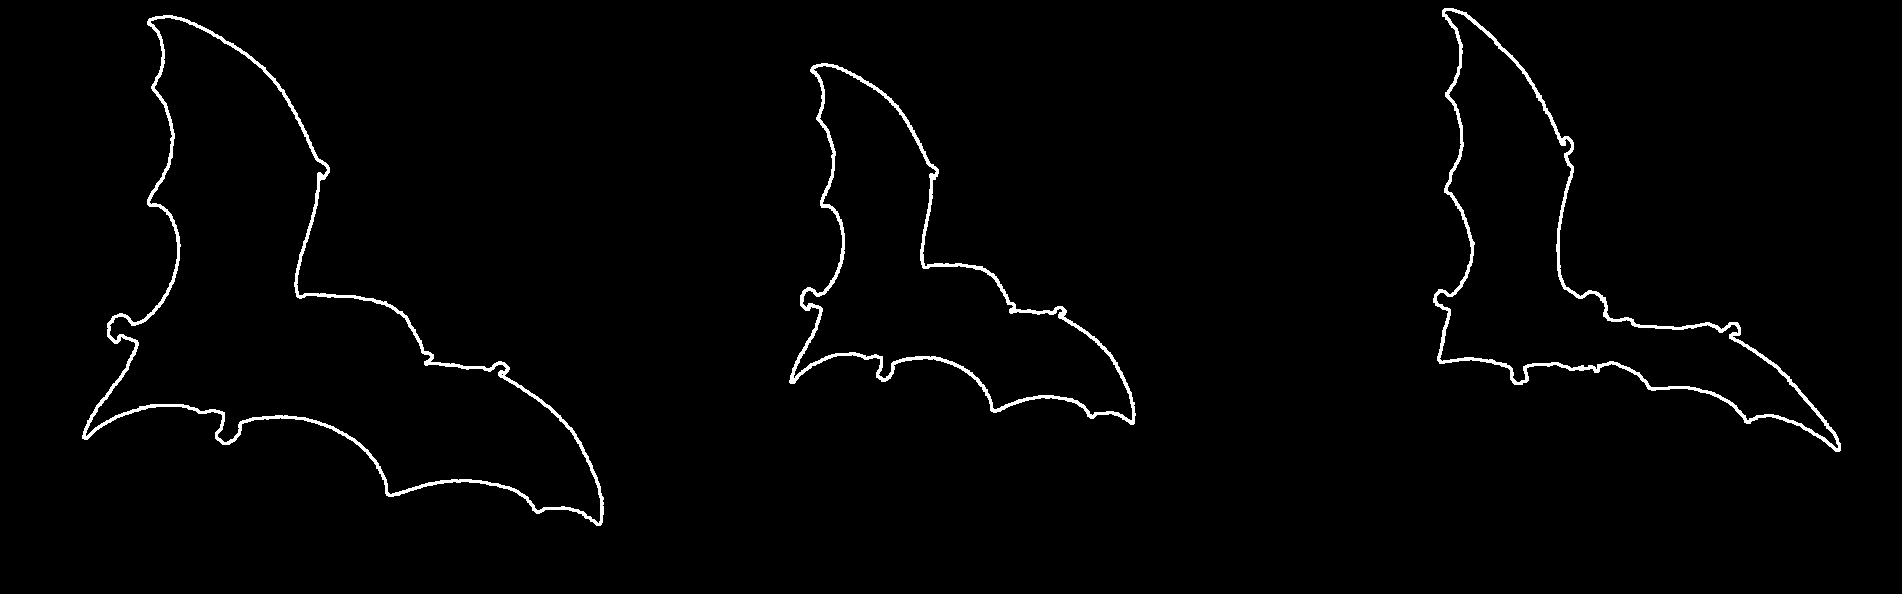



bell :
Error in alignment: 182.8544758014561
Runtime: 0.065521240234375  seconds


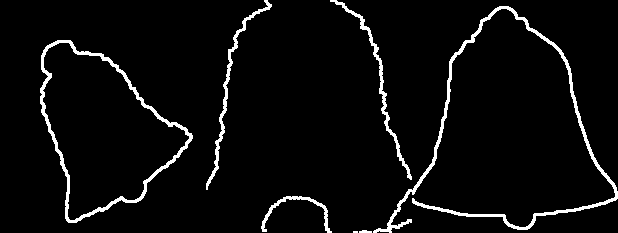



bird :
Error in alignment: 245.66670889948062
Runtime: 0.20978140830993652  seconds


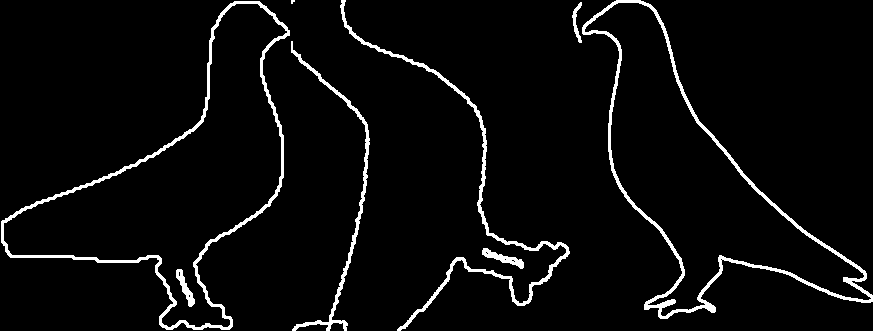



Bone :
Error in alignment: 321.06297605188126
Runtime: 0.21276378631591797  seconds


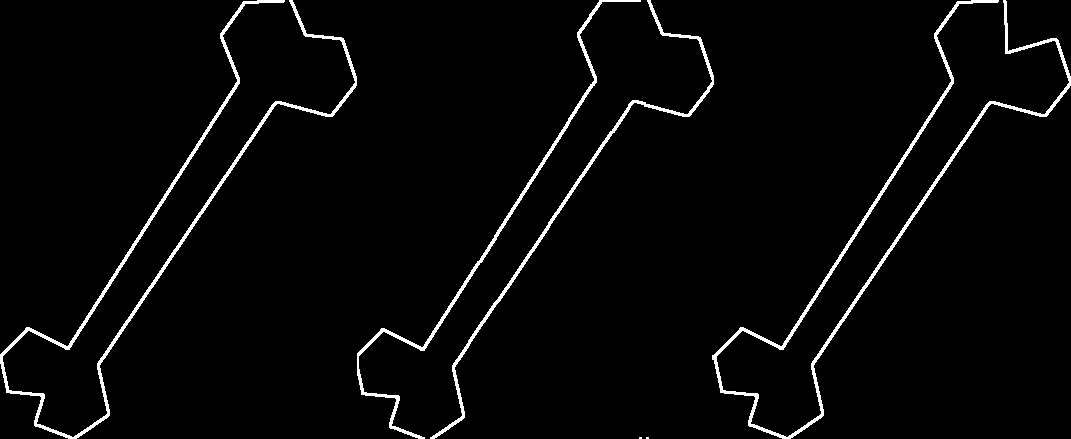



bottle :
Error in alignment: 246.58650966276264
Runtime: 0.03782773017883301  seconds


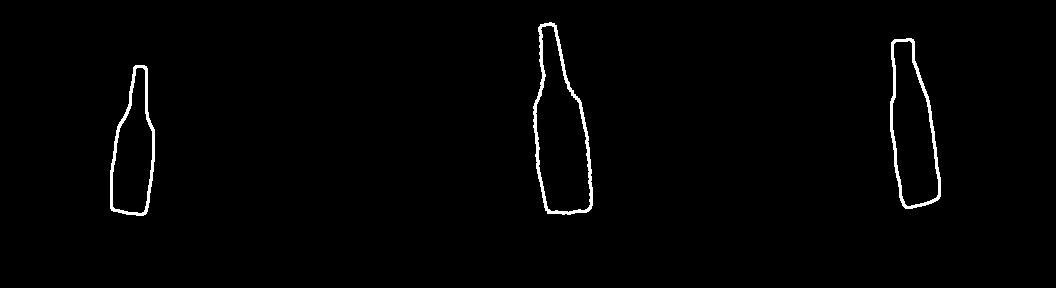



brick :
Error in alignment: 304.4194951133843
Runtime: 0.0414125919342041  seconds


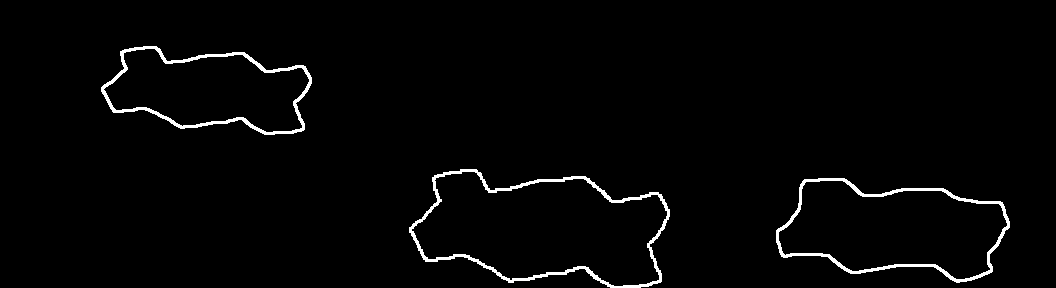



butterfly :
Error in alignment: 210.7330877394948
Runtime: 0.27408838272094727  seconds


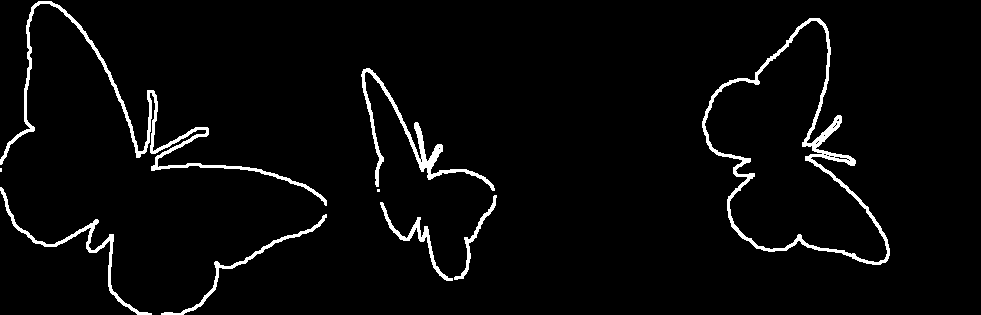



camel :
Error in alignment: 273.9955229176538
Runtime: 0.8367562294006348  seconds


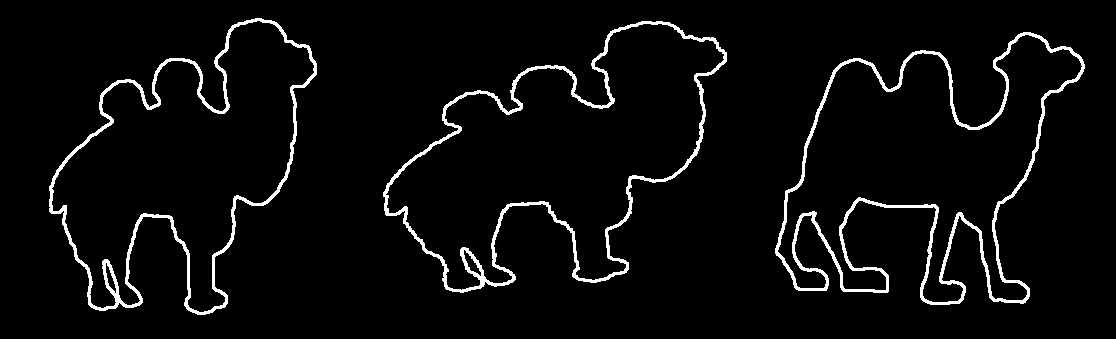



car :
Error in alignment: 243.11833170127017
Runtime: 0.04212641716003418  seconds


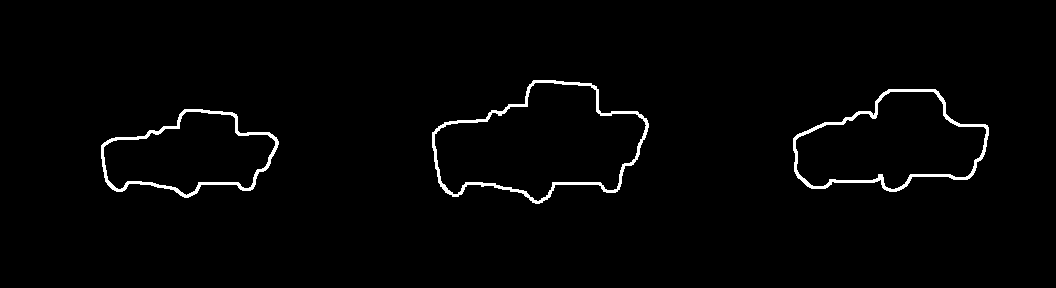



carriage :
Error in alignment: 284.04361265051693
Runtime: 0.30081868171691895  seconds


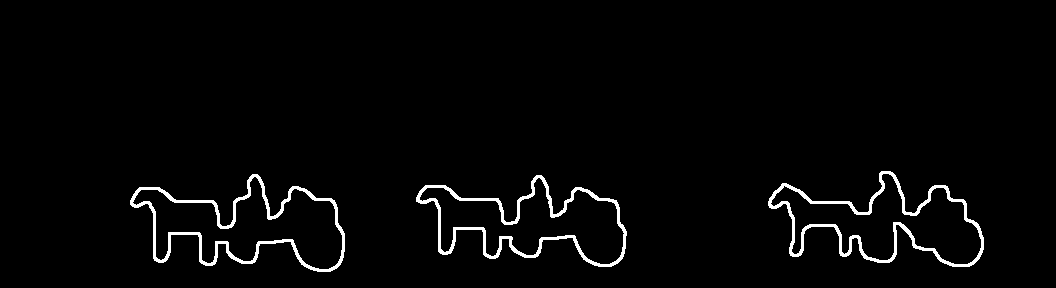



cattle :
Error in alignment: 368.57096299092115
Runtime: 1.561020851135254  seconds


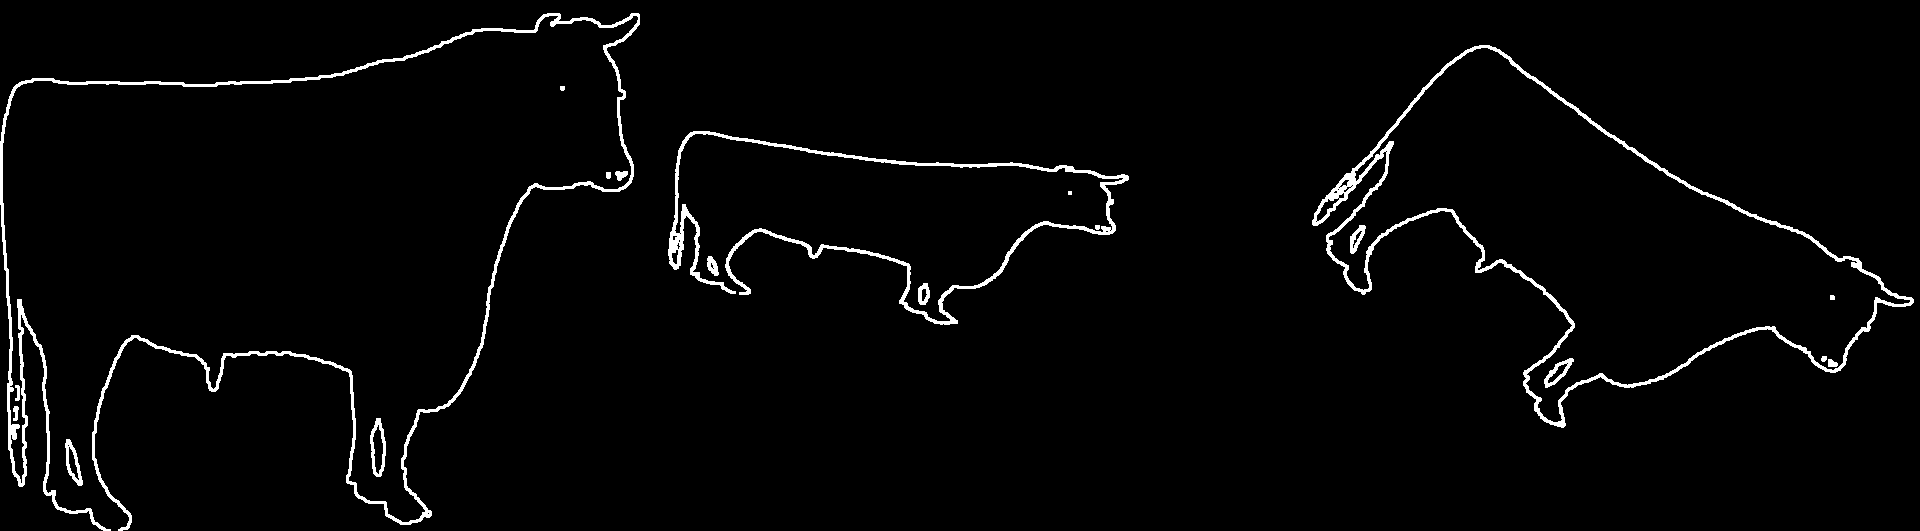



cellular_phone :
Error in alignment: 261.9945144530477
Runtime: 0.15158438682556152  seconds


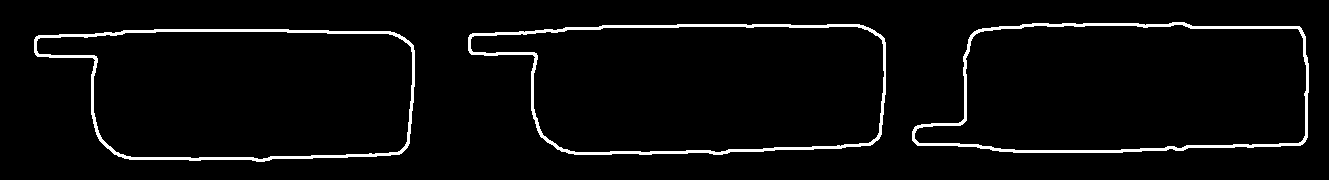



chicken :
Error in alignment: 153.9737269041597
Runtime: 0.15396571159362793  seconds


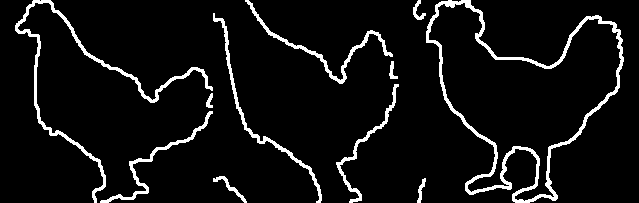



children :
Error in alignment: 156.34019593044252
Runtime: 0.019129037857055664  seconds


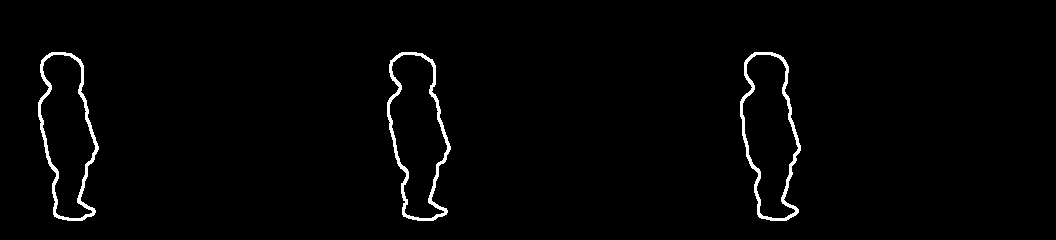



device7 :
Error in alignment: 383.3379573139192
Runtime: 1.3539881706237793  seconds


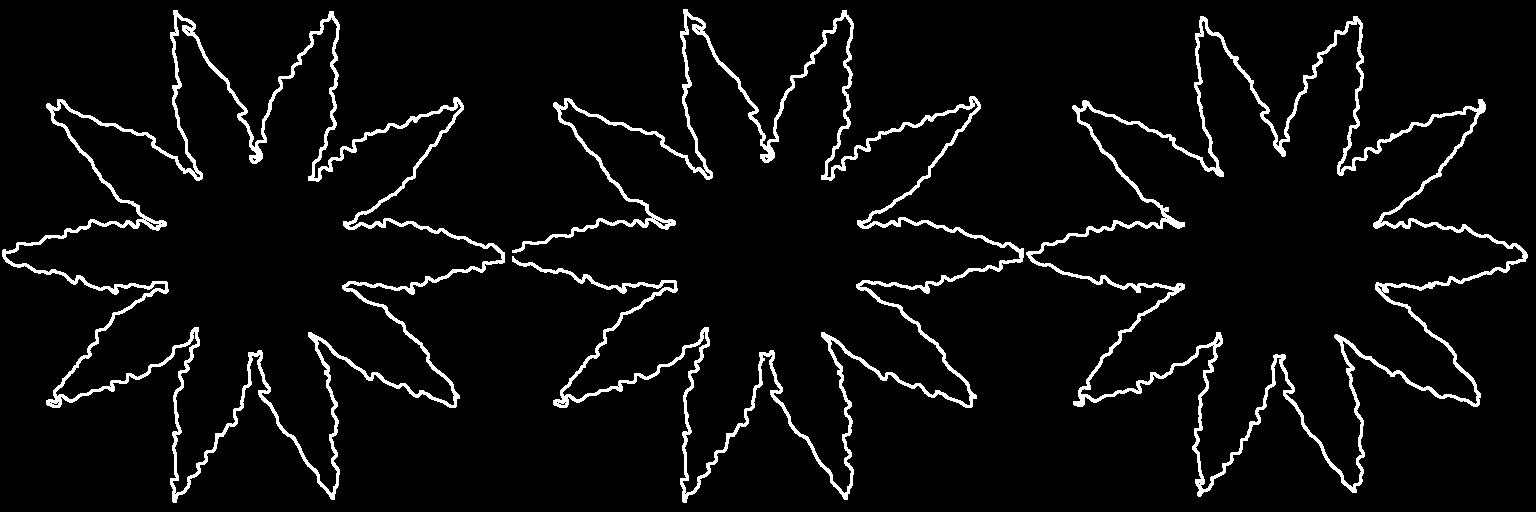



dog :
Error in alignment: 357.240285212594
Runtime: 1.6678276062011719  seconds


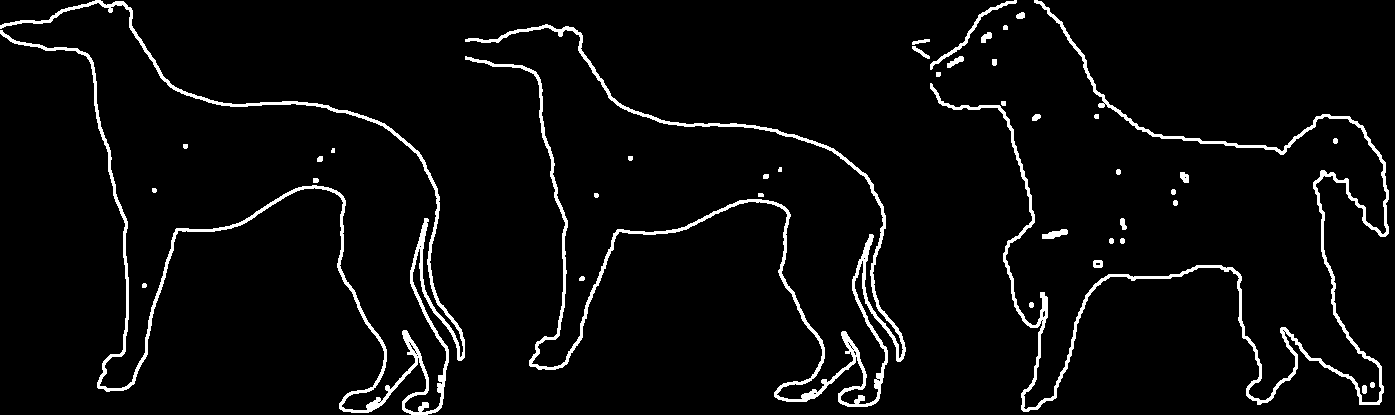



elephant :
Error in alignment: 566.157192395939
Runtime: 2.1573026180267334  seconds


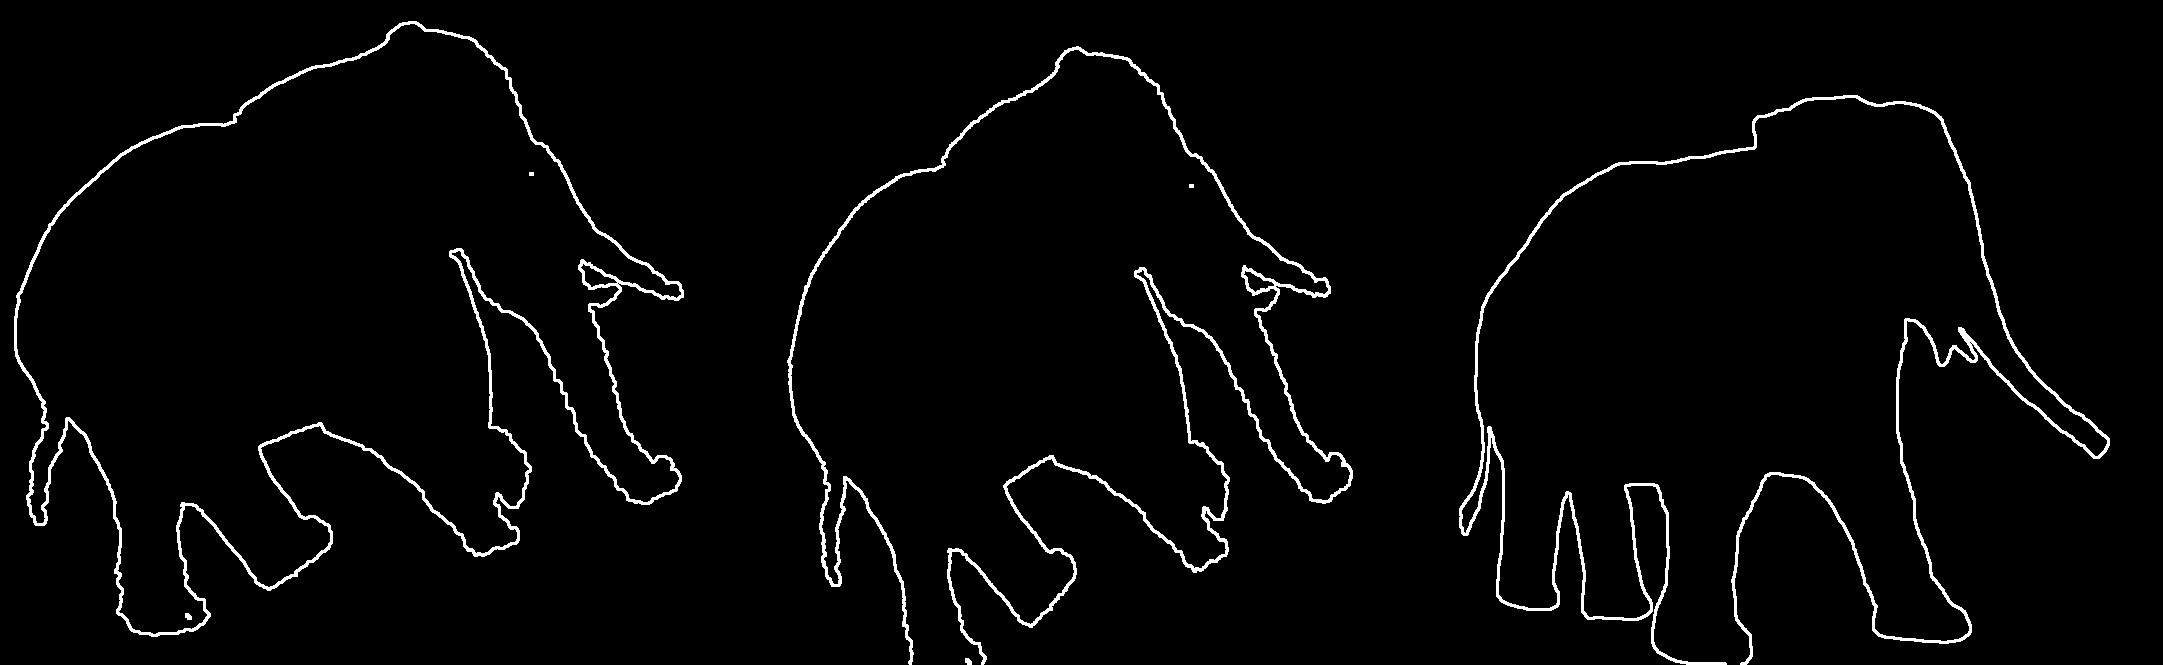



face :
Error in alignment: 232.9575544203047
Runtime: 0.09757828712463379  seconds


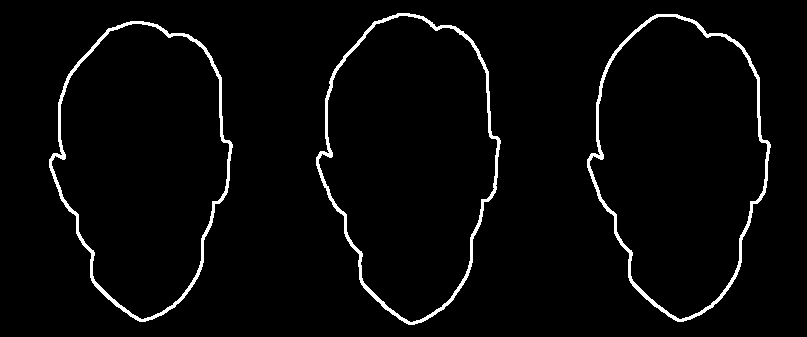



fork :
Error in alignment: 357.7992103912451
Runtime: 1.3274054527282715  seconds


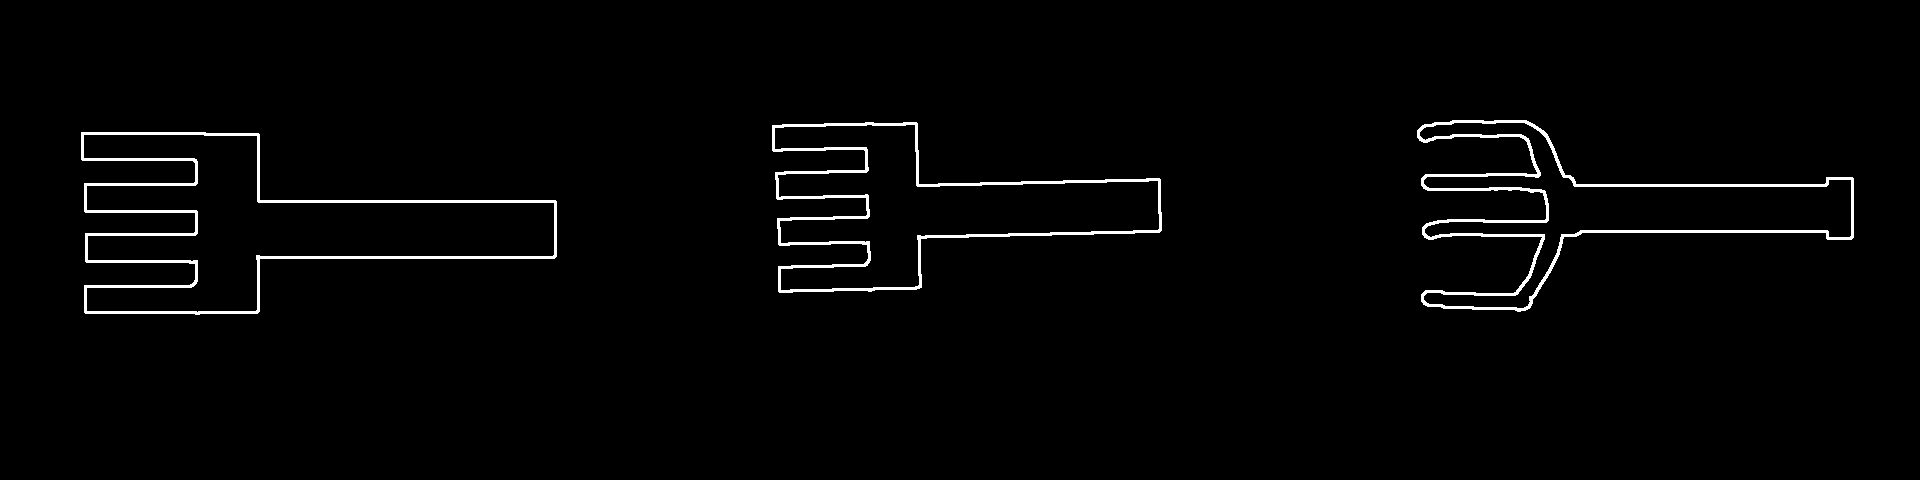



hammer :
Error in alignment: 162.8805862697613
Runtime: 0.0807197093963623  seconds


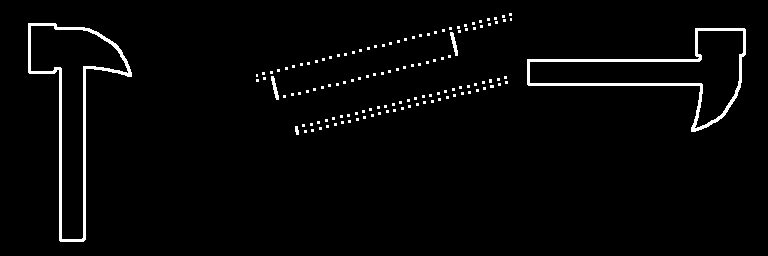



Heart :
Error in alignment: 328.2514868488008
Runtime: 0.22174501419067383  seconds


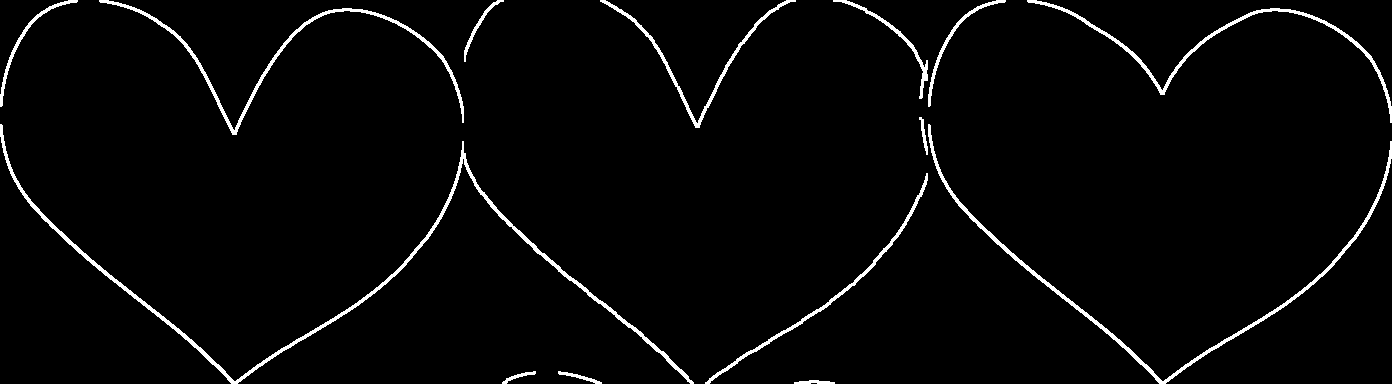



horse :
Error in alignment: 495.21621704450286
Runtime: 3.119081497192383  seconds


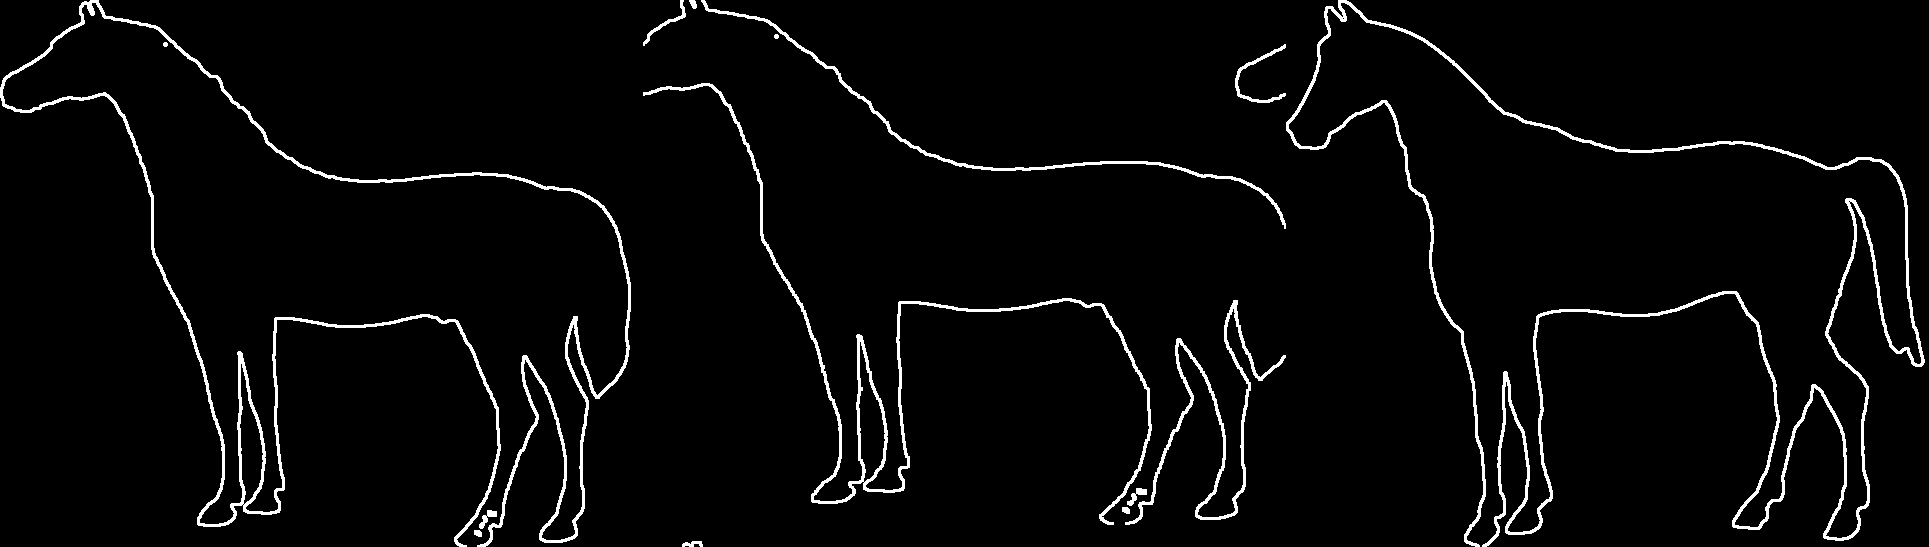



jar :
Error in alignment: 384.85488459982787
Runtime: 0.5795838832855225  seconds


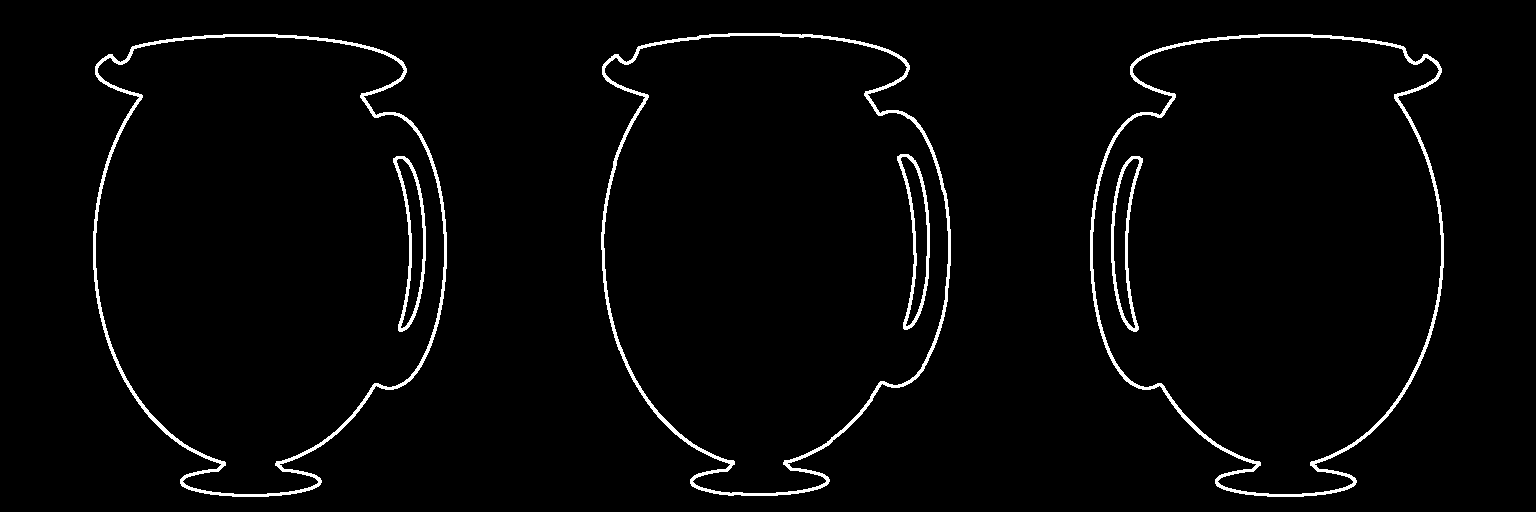



turtle :
Error in alignment: 252.73521278079056
Runtime: 0.20332765579223633  seconds


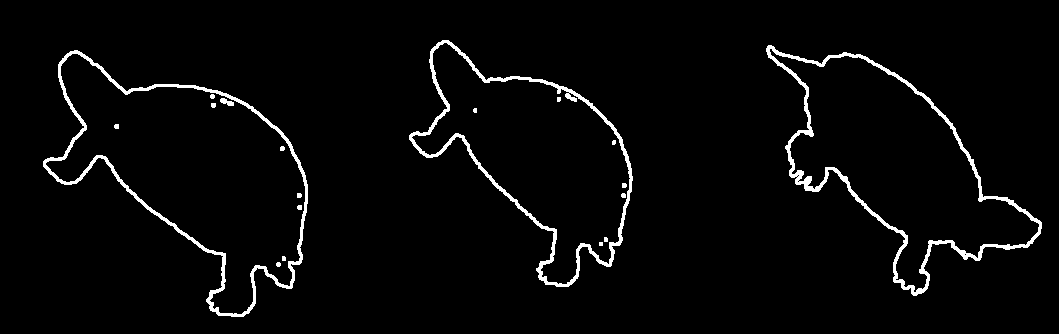

In [8]:
def findTransform(A, B):
    d = A.shape[1]

    A_centroid = np.mean(A, axis=0)
    B_centroid = np.mean(B, axis=0)
    A_shift = A - A_centroid
    B_shift = B - B_centroid

    H_mat = np.dot(A_shift.T, B_shift)
    U, S, Vt = np.linalg.svd(H_mat)
    Rot = np.dot(Vt.T, U.T)

    trans = B_centroid.T - np.dot(Rot, A_centroid.T)

    Transform_mat = np.identity(d + 1)
    Transform_mat[:d, :d] = Rot
    Transform_mat[:d, d] = trans

    return Transform_mat

def nearestNeighbor(X, Y):
    eucd_dist = np.sum((X[:, None, :] - Y[None, :, :]) ** 2, axis=2) ** 0.5
    nn_distance = np.min(eucd_dist, axis=1)
    nn_idx = np.argmin(eucd_dist, axis=1)

    return nn_distance, nn_idx

def ICP(edg_pt1, edg_pt2, T_init, no_iterations, tolerance):
    m = edg_pt1.shape[1]

    edg_pt1_ = np.ones((m + 1, edg_pt1.shape[0]))
    edg_pt2_ = np.ones((m + 1, edg_pt2.shape[0]))
    edg_pt1_[:m, :] = np.copy(edg_pt1.T)
    edg_pt2_[:m, :] = np.copy(edg_pt2.T)

    edg_pt1_ = np.dot(T_init, edg_pt1_)

    init_error = 0
    for i in range(no_iterations):
        nn_distance, nn_idx = nearestNeighbor(edg_pt1_[:m, :].T, edg_pt2_[:m, :].T)

        Transform_mat = findTransform(edg_pt1_[:m, :].T, edg_pt2_[:m, nn_idx].T)

        edg_pt1_ = np.dot(Transform_mat, edg_pt1_)

        mean_error = np.mean(nn_distance)
        if np.abs(init_error - mean_error) < tolerance:
            break
        init_error = mean_error

    Transform_mat = findTransform(edg_pt1, edg_pt1_[:m, :].T)

    return edg_pt1_


imgPath = '/content/part2_images/'

objList = ['apple', 'bat', 'bell', 'bird', 'Bone', 'bottle', 'brick',
           'butterfly', 'camel', 'car', 'carriage', 'cattle', 'cellular_phone',
           'chicken', 'children', 'device7', 'dog', 'elephant', 'face', 'fork',
           'hammer', 'Heart', 'horse', 'jar', 'turtle']
numObj = len(objList)
for i in range(numObj):
    im1 = cv2.imread(imgPath + objList[i] + '_1.png', 0)
    im2 = cv2.imread(imgPath + objList[i] + '_2.png', 0)

    x1, y1 = np.where(im1 == 255)
    x2, y2 = np.where(im2 == 255)

    transl_x =  np.mean(x1) - np.mean(x2)
    transl_y = np.mean(y1) - np.mean(y2)

    scale_x = np.var(x2) / np.var(x1)
    scale_y = np.var(y2) / np.var(y1)

    T_init = np.array([[scale_x, 0, transl_x],[0, scale_y, transl_y],[0, 0, 1]])

    edg_pt1 = np.array([x1, y1]).T
    edg_pt2 = np.array([x2, y2]).T

    t0 = time.time()
    result_edg_pts = ICP(edg_pt1, edg_pt2, T_init, 50, 0.005)
    runtime = time.time() - t0

    result_img = np.zeros_like(im1)
    for j in range(result_edg_pts.shape[1]):
        x = int(result_edg_pts[:, j][0])
        y = int(result_edg_pts[:, j][1])
        try:
            result_img[x, y] = 255
        except IndexError:
            pass

    error = evalAlignment(result_img, im2)
    print(objList[i],':')
    print('Error in alignment:', error)
    print('Runtime:', runtime,' seconds')
    cv2_imshow(displayAlignment(im1, im2, result_img, thick=True))
    print('\n')

## Write-up (15 pt)

1. (5 pts) Give a brief explanation of your algorithm, initialization, and model of the transformation.

2. (10 pts) For each result, give:
  1.   The alignment display
  2.   The final error
  3.   The runtime






**Algorithm:**  

1. **Edge Points** : Find the edge points of both the image1 and image2. 
2. **Compute Initial Transformation** : Computing translation, scaling by calculating the centroid and variance respectfully, for the determined edgepoints.
3. **Iterative Closest Point** :  
Edge points of the image1 are transformed by applying the intial transformation.  
For a set number of iterations, find the nearest neighbours for each point between image1 and image2 resulting in their minimum distances and respective indices.  
Calculate the transformation between the edgepoints of image1 and image2 based on the nearest matches on the image2.  
Edge points of the image1 are transformed by using the above calculated transformation matrix.  
Iteratively, compute the error in the mean distances between the transformed image and image2 and check if the error is lessthan the user-defined tolerance.  
4. **Final Transformation** : Compute the final transformation matrix.
5. **Alignment Error** : Provided the helper functions, calculate the error in alignment between the aligned image and the destination image. 

# Part 3: Object Instance Recognition (20 points)

## Overview
This problem explores the Lowe-style object instance recognition.

Implement the nearest neighbor distance ratio test using the pre-computed SIFT features SIFT_features.mat provided in the supplementary material. The Frame1, Frame2 indicate the 2D position, scales, and the orientation of the descriptors and Descriptor1, Descriptor2 are the correspondin 128-D SIFT features. Display the matches like this:

<img src="https://drive.google.com/uc?id=1mULTvHYeP5uj_vi7nwWThBHkDbv1eSue" width="1000"/>



## Data

In [9]:
# Download Data -- run this cell only one time per runtime
!gdown 10ByzpFbB-z178VGjwmCwc95wInD8vpNM # SIFT Features
!gdown 1KLWGMtDEMNNrmzd3Qezrs2-NQR52OfoU # Stop sign image 1
!gdown 13y-o1vdGN6CqqPuUcgU7pIxODTxrYS7J # Stop sign image 1

Downloading...
From: https://drive.google.com/uc?id=10ByzpFbB-z178VGjwmCwc95wInD8vpNM
To: /content/SIFT_features.mat
100% 347k/347k [00:00<00:00, 82.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1KLWGMtDEMNNrmzd3Qezrs2-NQR52OfoU
To: /content/stop1.jpg
100% 15.6k/15.6k [00:00<00:00, 22.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=13y-o1vdGN6CqqPuUcgU7pIxODTxrYS7J
To: /content/stop2.jpg
100% 224k/224k [00:00<00:00, 101MB/s]


## Code (10 pts)

Number of matches(Nearest neighbour distances): 22


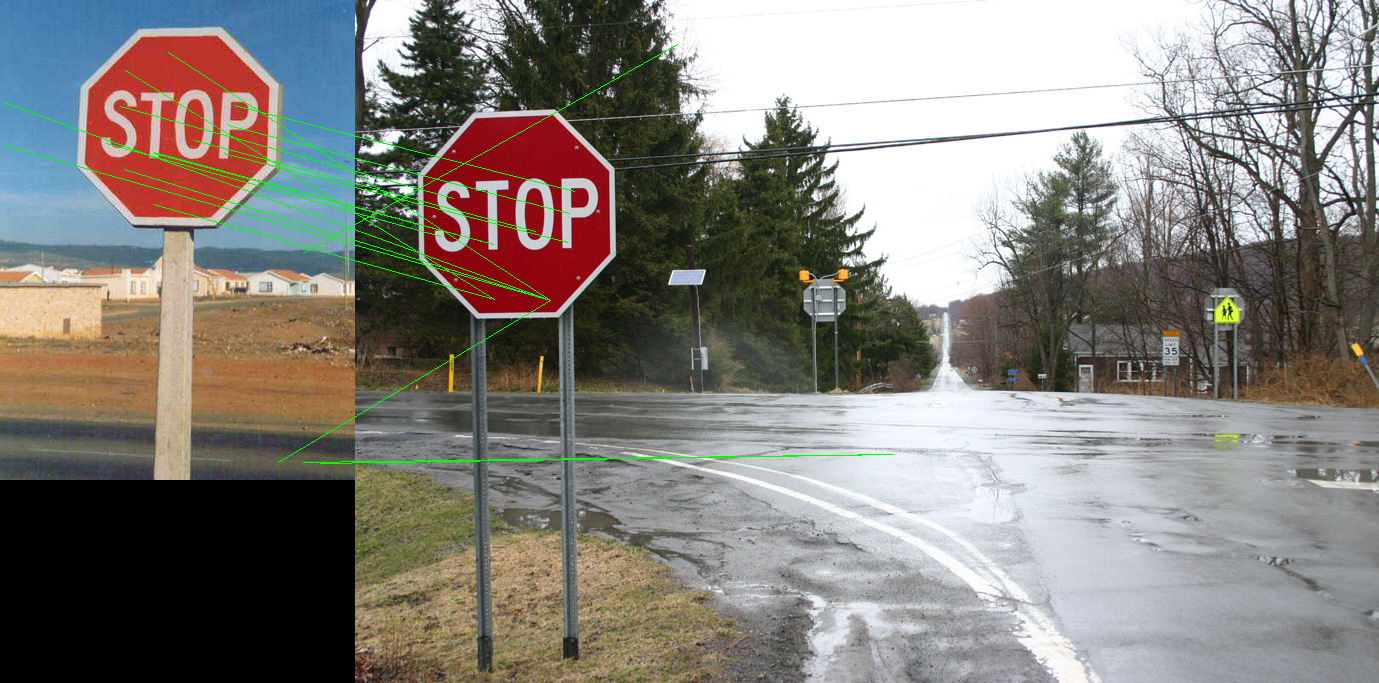

Number of matches(Distance ratio): 33


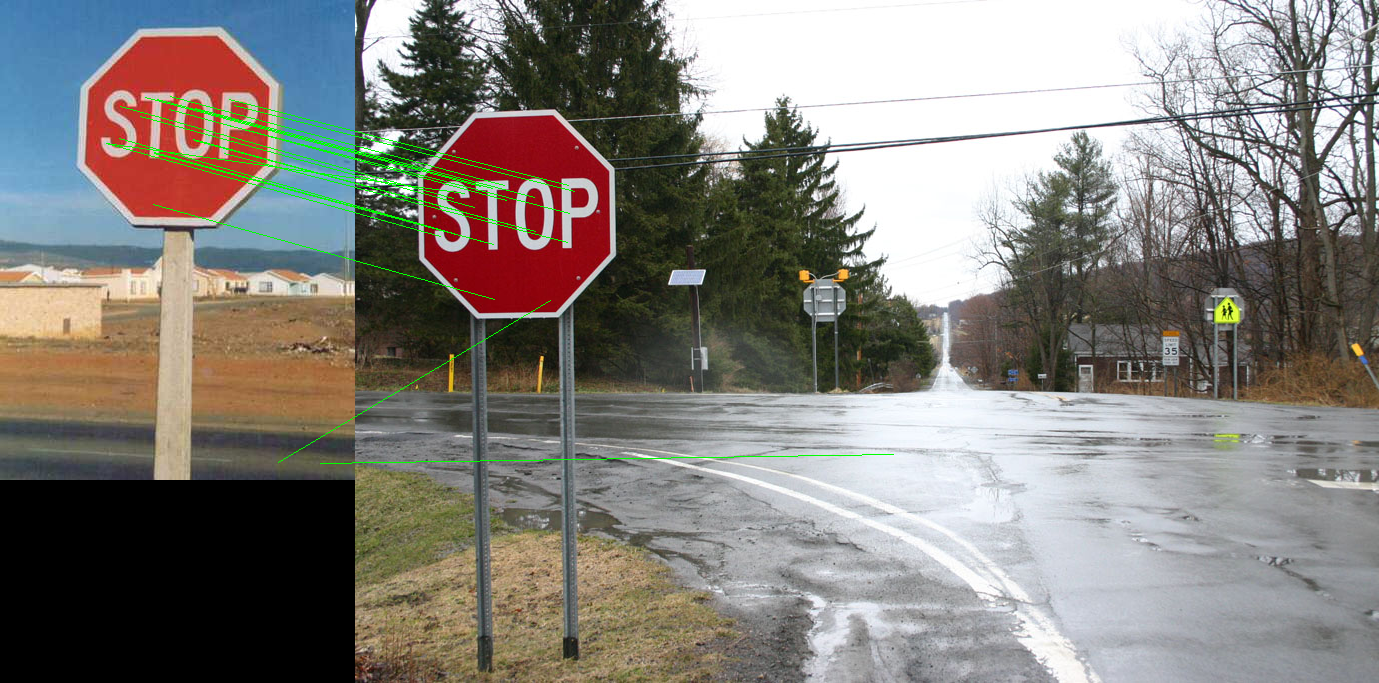

In [10]:
img1 = cv2.imread('/content/stop1.jpg')
img2 = cv2.imread('/content/stop2.jpg')
## inside the sift are:
## Descriptor1, Descriptor2: SIFT features from image 1 and image 2
## Frame1, Frame2: position, scale, rotation of keypoints
data = loadmat('/content/SIFT_features.mat')
Frame1 = data['Frame1']
Descriptor1 = data['Descriptor1']
Frame2 = data['Frame2']
Descriptor2 = data['Descriptor2']


## matches: a 2 x N array of indices that indicates which keypoints from image
## 1 match which points in image 2

## Display the matched keypoints
nearest_th, dist_ratio_th = [], []
for i in range(Descriptor1.shape[1]):
  ssd = []
  for j in range(Descriptor2.shape[1]):
    sq_distances = (Descriptor1[:,i] - Descriptor2[:,j])**2
    ssd.append(np.sum(sq_distances))
  nearest_1 = np.min(ssd)
  index_1 = np.argmin(ssd)
  ssd[index_1]= np.max(ssd)
  nearest_2 = np.min(ssd)
  index_2 = np.argmin(ssd)

  if nearest_1 < 3500:
    nearest_th.append([i, index_1])

  ratio_dist = nearest_1 / nearest_2
  if ratio_dist < 0.8:
    dist_ratio_th.append([i, index_1])

#Visualizing the results
final_img = np.zeros((img2.shape[0], img1.shape[1]+img2.shape[1],3), dtype=np.float32)
final_img[0:480,0:355] = img1
final_img[:,355:1379] = img2
final_img_2 = final_img.copy()

print('Number of matches(Nearest neighbour distances):',len(nearest_th))
for i in range(len(nearest_th)):
    cv2.line(final_img, (int(Frame1[0,nearest_th[i][0]]), int(Frame1[1,nearest_th[i][0]])), (int(Frame2[0,nearest_th[i][1]])+355, int(Frame2[1,nearest_th[i][1]])), (0,255,0), 1)
cv2_imshow(final_img)

print('Number of matches(Distance ratio):',len(dist_ratio_th))
for i in range(len(dist_ratio_th)):
    cv2.line(final_img_2, (int(Frame1[0,dist_ratio_th[i][0]]), int(Frame1[1,dist_ratio_th[i][0]])), (int(Frame2[0,dist_ratio_th[i][1]])+355, int(Frame2[1,dist_ratio_th[i][1]])), (0,255,0), 1)
cv2_imshow(final_img_2)

## Write-up (10 pts)

(5 pts) Display:

1. the matches by thresholding nearest neighbor distances.

2. the matches by thresholding the distance ratio. 

(5 pts) Describe the differences of (1) and (2).

**Feature Matching:**  
1. Nearest Neighbor Distances: In this method, the sum of squared distances are calculated for each descriptor in image1 with each descriptor in image2.

2. Distance Ratio: In this method, ratio of the minimum and the second minimum nearest neighbour are calculated.

**Difference:** In thresholding the SSD for the nearest neighbour distance method, the threshold that is to be set is difficult which can be inaccurate as a correct match can have a larger distance than an incorrect match. Therefore, distance ratio is better strategy which reduces 90% of the false matches, as a low distance ratio implies a good match while a high distance ratio can be an ambigous match.